# Project: Wrangling and Analyze Data

## Table of Contents
[Data Gathering](#gathering)<br>
[Assessing Data](#assessing)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Quality Issues](#quality1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Tidiness Issues](#tidiness1)<br>
[Cleaning Data](#cleaning)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Quality Issues](#quality2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Tidiness Issues](#tidiness2)<br>
[Storing Data](#storing)<br>
[Analyzing and Visualizing Data](#analyzing)

<a id="gathering"></a>
## Data Gathering
In the cells below, we are going to gather the three pieces of data for this project and load them in the notebook.

First, we are going to directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [66]:
import pandas as pd
import numpy as np
import requests
import io
import tweepy
import json
import re
import matplotlib.pyplot as plt
import matplotlib.figure

%matplotlib inline

In [67]:
archive_df = pd.read_csv("twitter-archive-enhanced.csv")
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


Secondly, we will use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [68]:
prediction_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
prediction_data = requests.get(prediction_url).content
prediction_df = pd.read_csv(io.StringIO(prediction_data.decode("utf-8")), sep="\t")
#prediction_df = pd.read_csv(prediction_url, sep="\t")
prediction_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Thirdly, we are going to load "tweet-json.txt" file using json library to extract some properties including favorite_count and retweet_count.

In [69]:
# Create a list to store data extracted from the JSON file
json_data = []

# Open the JSON file and iterate through its lines
with open("tweet-json.txt", 'r') as file:
    # Each line in this file represents a JSON object, each of which is composed of a set of objects
    for line in file:
        # Loading the line object
        line_data = json.loads(line)
        
        # Extracting the targeted columns
        tweet_id = line_data["id"]
        favorite_count = line_data["favorite_count"]
        retweet_count = line_data["retweet_count"]
        full_text = line_data["full_text"]
        
        # Extract dog's name from full_text
        dog_name_sentence = re.search('([Tt]his is\s\w+)', full_text) or re.search('([Mm]eet\s\w+)', full_text)
        dog_name = ""
        
        # Check that our search returned a value
        if(dog_name_sentence):
            dog_name = dog_name_sentence.group().split()[-1]
        
        # Add extracted data to a list
        json_data.append({'tweet_id': tweet_id, 
                          'favorite_count': favorite_count, 
                          'retweet_count': retweet_count,
                          'name': dog_name
                         })
        
# Create a dataframe out of the constructed list
json_df = pd.DataFrame(json_data, columns=["tweet_id", "name", "favorite_count", "retweet_count"])

json_df.head()

,tweet_id,name,favorite_count,retweet_count
0,892420643555336193,Phineas,39467,8853
1,892177421306343426,Tilly,33819,6514
2,891815181378084864,Archie,25461,4328
3,891689557279858688,Darla,42908,8964
4,891327558926688256,Franklin,41048,9774


<a id="assessing"></a>
## Assessing Data
In this section, we are going to detect and document nine (9) quality issues and four (4) tidiness issues. Both visual assessment and programmatic assessement are used to assess the data.

The following key points to be considered when we access the data:
* We only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* We do not need to gather the tweets beyond August 1st, 2017. We can, but note that we won't be able to gather the image predictions for these tweets since wedon't have access to the algorithm used.



In [70]:
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [71]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [72]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In the few lines below, we are going to check the values existing in several columns in archive table.

In [73]:
list(archive_df.source.unique())

['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
 '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
 '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>']

In [74]:
list(archive_df.doggo.unique())

['None', 'doggo']

In [75]:
list(archive_df.floofer.unique())

['None', 'floofer']

In [76]:
list(archive_df.pupper.unique())

['None', 'pupper']

In [77]:
list(archive_df.puppo.unique())

['None', 'puppo']

Let's check to see if there are missing dog names in archive table.

In [78]:
archive_df[(archive_df.name.empty) | (archive_df.name == "None")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,19607400.0,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
37,885167619883638784,NaN,NaN,2017-07-12 16:03:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a corgi undercover as a malamute....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/885167619...,13,10,None,None,None,None,None
41,884441805382717440,NaN,NaN,2017-07-10 15:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I present to you, Pup in Hat. Pup in Hat is gr...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/884441805...,14,10,None,None,None,None,None


In [79]:
prediction_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [80]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [81]:
prediction_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [82]:
json_df

,tweet_id,name,favorite_count,retweet_count
0,892420643555336193,Phineas,39467,8853
1,892177421306343426,Tilly,33819,6514
2,891815181378084864,Archie,25461,4328
3,891689557279858688,Darla,42908,8964
4,891327558926688256,Franklin,41048,9774
5,891087950875897856,,20562,3261
6,890971913173991426,Jax,12041,2158
7,890729181411237888,,56848,16716
8,890609185150312448,Zoey,28226,4429
9,890240255349198849,Cassie,32467,7711


In [83]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id          2354 non-null int64
name              2354 non-null object
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


In [84]:
json_df.describe()

,tweet_id,favorite_count,retweet_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,8080.968564,3164.797366
std,6.852812e+16,11814.771334,5284.770364
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,1415.000000,624.500000
50%,7.194596e+17,3603.500000,1473.500000
75%,7.993058e+17,10122.250000,3652.000000
max,8.924206e+17,132810.000000,79515.000000


Let's check to see if we have duplicates in our datasets

In [85]:
all_columns = pd.Series(list(archive_df) + list(prediction_df) + list(json_df))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
30        name
dtype: object

In [86]:
archive_df[archive_df.expanded_urls.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
75,878281511006478336,NaN,NaN,2017-06-23 16:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Shadow. In an attempt to reach maximum zo...,NaN,NaN,NaN,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
76,878057613040115712,NaN,NaN,2017-06-23 01:10:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Emmy. She was adopted today. Massive r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
98,873213775632977920,NaN,NaN,2017-06-09 16:22:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sierra. She's one precious pupper. Abs...,NaN,NaN,NaN,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
126,868552278524837888,NaN,NaN,2017-05-27 19:39:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Cooper. His expression is the sam...,NaN,NaN,NaN,"https://www.gofundme.com/3ti3nps,https://twitt...",12,10,Cooper,None,None,None,None
135,866450705531457537,NaN,NaN,2017-05-22 00:28:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jamesy. He gives a kiss to every other...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/866450705...,13,10,Jamesy,None,None,pupper,None
136,866334964761202691,NaN,NaN,2017-05-21 16:48:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Coco. At first I thought she was a clo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


And now, let's take a look at the dog names we have in our dataset.

In [87]:
archive_df.name.value_counts()

None            745
a                55
Charlie          12
Cooper           11
Lucy             11
Oliver           11
Lola             10
Tucker           10
Penny            10
Winston           9
Bo                9
the               8
Sadie             8
Bailey            7
Daisy             7
an                7
Buddy             7
Toby              7
Leo               6
Stanley           6
Scout             6
Rusty             6
Bella             6
Jack              6
Jax               6
Koda              6
Milo              6
Oscar             6
Dave              6
George            5
               ... 
Rodney            1
Tupawc            1
Rorie             1
Kirk              1
Dante             1
Wishes            1
Brutus            1
Julio             1
Dunkin            1
Bobble            1
Jeb               1
Stephanus         1
Cheryl            1
Willow            1
Finnegus          1
Strider           1
Shikha            1
unacceptable      1
Jareld            1


<a id="quality1"></a>
### Quality issues
Here, we list the quality issues found in our tables:

#### archive table
1. Erroneous data types (tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp)

2. Dataset contains data beyond 08/01/2017

3. Values in 'source' column are presented as hyperlinks instead of URLs

4. Some values are missing from the 'expanded_urls' column

5. expanded_urls in several rows contain multiple URLs

6. Some values in the 'name' column are set to odd values such as 'a', 'an', and 'the'

7. "None" and empty values in several columns
 
#### prediction table

8. p1 has underscores, and words don't always start with capital letters
9. Non-descriptive or inconsistent column name (p1, p1_conf, p1_dog...)

<a id="tidiness1"></a>
### Tidiness issues
The following changes need to be made in order to improve the tidiness of our data:

#### archive table

1. Retweet columns (retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp) are irrelevant

2. Four columns (doggo, floofer, pupper, puppo) for a single variable 'dog stage'

3. archive table should be merged with json table

#### prediction table

4. Prediction table should be merged with archive table

<a id="cleaning"></a>
## Cleaning Data
In this section, we are going to clean all of the issues listed above, but before that, we are going to make copies of our datasets.

In [88]:
archive_clean_df = archive_df.copy()
prediction_clean_df = prediction_df.copy()
json_clean_df = json_df.copy()

<a id="quality2"></a>
### Quality Issues ###
### Issue #1: ####  
`archive`: Erroneous data types (tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)

#### Define: 
Convert datatypes to the correct ones. For the float datatypes (i.e., "in_reply_to_status_id", "in_reply_to_user_id") null values need to be filled with zeros before converting them to integer.

#### Code

In [89]:
# String datatype are used for id columns instead of integer for its felxibility, 
# and we are not going to perform calculations on it
# Read https://stackoverflow.com/questions/42255754/phone-number-should-be-a-string-or-some-numeric-type-that-have-capacity-to-save
archive_clean_df.tweet_id = archive_clean_df.tweet_id.astype('object')
prediction_clean_df.tweet_id = prediction_clean_df.tweet_id.astype('object')
json_clean_df.tweet_id = json_clean_df.tweet_id.astype('object')
archive_clean_df.in_reply_to_status_id = archive_clean_df.in_reply_to_status_id.astype('object')
archive_clean_df.in_reply_to_user_id = archive_clean_df.in_reply_to_user_id.astype('object')
archive_clean_df.source = archive_clean_df.source.astype("category")
archive_clean_df.timestamp = pd.to_datetime(archive_clean_df.timestamp)

#### Test

In [90]:
archive_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null category
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: category(1), da

### Issue #2: ####  
`archive`: Data contains data beyond 08/01/2017 as well as retweets

#### Define: 
Filter data to only keep tweets posted before 08/02/2017 for the those that have no retweets

#### Code

In [91]:
# Filter data to exclude records beyond August 1st, 2017, as well as retweets
before_count = len(archive_clean_df)
archive_clean_df = archive_clean_df[(archive_clean_df.timestamp < "08/02/2017") & 
                                    (archive_clean_df.retweeted_status_id.isnull())]
after_count = len(archive_clean_df)
removed = before_count - after_count
print(removed, " records deleted.")

181  records deleted.


#### Test

In [92]:
archive_clean_df[archive_clean_df.timestamp >= "08/02/2017"]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Issue #3: ####  
`archive`  Values in 'source' column are presented as hyperlinks instead of URLs

#### Define: 
Extract URLs from text using extract() and regex

#### Code

In [93]:
# Extract URLs from hyperlinks
pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)' 
archive_clean_df.source = archive_clean_df.source.str.extract(pattern, expand=False)

#### Test

In [94]:
archive_clean_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [95]:
archive_clean_df.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50,http://twitter.com/download/iphone,Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52,http://twitter.com/download/iphone,This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54,http://twitter.com/download/iphone,Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30,http://twitter.com/download/iphone,This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08,http://twitter.com/download/iphone,Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


### Issue #4: ####  
`archive` Some values are missing from the 'expanded_urls' column

#### Define: 
Build the URLs using this patten 'https://twitter.com/dog_rates/status/' + tweet_id + '/photo/1'. A user-defined function along with Lambda will be used to resolve this issue.

#### Code

In [96]:
# Fix tweet URL
def fix_url(row):
    """Takes a row, and it returns twitter URL constructed using the URL pattern used by Twitter"""
    return 'https://twitter.com/dog_rates/status/'+str(row['tweet_id'])+'/photo/1'


archive_clean_df.expanded_urls = archive_clean_df.apply(lambda row: fix_url(row), axis=1)
archive_clean_df.rename(columns={"expanded_urls":"expanded_url"})

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_url,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,http://twitter.com/download/iphone,Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,http://twitter.com/download/iphone,Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890971913...,13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,http://twitter.com/download/iphone,When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,http://twitter.com/download/iphone,This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,http://twitter.com/download/iphone,This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


#### Test

In [97]:
archive_clean_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [98]:
archive_df.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


### Issue #5: ####  
`archive` expanded_urls in several rows contain multiple URLs

#### Define: 
Issue resolved by resolving issue #5

### Issue #6: ####  
`archive` Some values in the 'name' column are set to odd values such as 'a', 'an', and 'the'

#### Define: 
These values are saved in the dataset in lowercase and hence, we can locate and mask them with a unified values, such as an empty string, which can be replaced later with NaN. A user-defined function alomg with Lambda are used to accomplish this goal

#### Code

In [99]:
# Fix dog names
def fix_name(row):
    """
    Takes a data row, and returns empty string if the passed value is in lowercase. 
    Othewise, it returns the same value
    """
    name = str(row["name"])
    if(name.islower()):
        return ""
    else:
        return name
    
    
archive_clean_df.name = archive_clean_df.apply(lambda row: fix_name(row), axis=1)

#### Test

In [100]:
archive_clean_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None



**Note:** Issue #7, which is concerned with fixing the "None", and empty values, will be skipped for now until we resolve all other issues (both quality and tidiness issues). This will allow us to work on all these values in the final dataset at once.


### Issue #8: ####  
`prediction` 'p1' values have underscores, and words don't always start with capital letters

#### Define: 
 Remove "_" by replacing them with "" (empty string), and capitalize the first letter of each word of the resulting text.

#### Code

In [101]:
prediction_clean_df["p1"] = prediction_clean_df["p1"].str.replace("_"," ").str.title()

#### Test

In [102]:
prediction_clean_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [103]:
prediction_clean_df.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Paper Towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,Orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


### Issue #9: ####  
`prediction` Non-descriptive or inconsistent column name (p1, p1_conf, p1_dog...)

#### Define: 
 Extract the columns we are going to work with, then rename them to descriptive name.

#### Code

In [104]:
# Extract main tweet's information as well as p1 columns
prediction_clean_df = prediction_clean_df.loc [:,['tweet_id', 'jpg_url', 'p1', 'p1_conf', 'p1_dog']]

# Rename p1 columns
prediction_clean_df.rename(columns={"p1":"probability", 
                                    "p1_conf":"probability_conf", 
                                    "p1_dog":"is_dog"}, 
                           inplace=True)

#### Test

In [105]:
prediction_clean_df.columns

Index(['tweet_id', 'jpg_url', 'probability', 'probability_conf', 'is_dog'], dtype='object')

<a id="tidiness2"></a>
### Tidiness issues
Here, we list the tidiness issues found in our tables:

### Issue #1: ####  
`archive`: retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp columns are irrelevant

#### Define: 
Drop retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp columns. These columns have no use since we are only concerned with original tweets (i.e., no retweets).

#### Code

In [106]:
archive_clean_df.drop(columns=["retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp"], inplace=True)

#### Test

In [107]:
archive_clean_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Issue #2: ####  
`archive` Four columns (doggo, floofer, pupper, puppo) for a single variable (dog_stage)

#### Define: 
Combine the four columns into one column to hold the dog stage value, and drop the original columns. The four values will be concatenated and saved into the new column.

#### Code

In [108]:
# Create a list of the columns that need cleaning before extracting our data
cols = ["doggo", "floofer", "pupper", "puppo"]
archive_clean_df[cols] = archive_clean_df[cols].replace("None", "")

# Combine the values, then format them accordingly for better readbility
archive_clean_df["stage"] = archive_clean_df.doggo + archive_clean_df.floofer + archive_clean_df.pupper + archive_clean_df.puppo
archive_clean_df.loc[archive_clean_df.stage =="doggopuppo", "stage"] = "doggo, puppo"
archive_clean_df.loc[archive_clean_df.stage =="doggofloofer", "stage"] = "doggo, floofer"
archive_clean_df.loc[archive_clean_df.stage =="doggopupper", "stage"] = "doggo, pupper"

# Drop the original (four) columns
archive_clean_df.drop(columns=cols, inplace=True)

#### Test

In [109]:
archive_clean_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,


In [110]:
archive_clean_df.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50,http://twitter.com/download/iphone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52,http://twitter.com/download/iphone,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,,
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54,http://twitter.com/download/iphone,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,,
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30,http://twitter.com/download/iphone,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,,
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08,http://twitter.com/download/iphone,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,None,


### Issue #3: ####  
archive table should be merged with json table

#### Define: 
A left join (using merge()) between archive table and json table will allow us to get more out of our data.

**Note:** column "name" should be dropped before mergin the tables. This column was created while processing the json file with hope to find it more complete than the column that came with the archive dataset, but it was just the same. 

#### Code

In [111]:
json_clean_df.drop(columns=["name"], inplace=True)
archive_clean_df = archive_clean_df.merge(json_clean_df, how="left", left_on="tweet_id", right_on="tweet_id")

#### Test

In [112]:
archive_clean_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,39467,8853
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,33819,6514
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,25461,4328
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,42908,8964
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,41048,9774


In [113]:
archive_clean_df.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,favorite_count,retweet_count
2170,666049248165822465,NaN,NaN,2015-11-16 00:24:50,http://twitter.com/download/iphone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,,111,41
2171,666044226329800704,NaN,NaN,2015-11-16 00:04:52,http://twitter.com/download/iphone,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,,,311,147
2172,666033412701032449,NaN,NaN,2015-11-15 23:21:54,http://twitter.com/download/iphone,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,,,128,47
2173,666029285002620928,NaN,NaN,2015-11-15 23:05:30,http://twitter.com/download/iphone,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,,,132,48
2174,666020888022790149,NaN,NaN,2015-11-15 22:32:08,http://twitter.com/download/iphone,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,None,,2535,532


### Issue #4: ####  
Prediction table should be merged with archive table

#### Define: 
A left join (using merge()) between archive table and prediction table will allow us to get more out of our data.

#### Code

In [114]:
archive_clean_df = archive_clean_df.merge(prediction_clean_df, how="left", left_on="tweet_id", right_on="tweet_id")

#### Test

In [115]:
archive_clean_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,favorite_count,retweet_count,jpg_url,probability,probability_conf,is_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,39467,8853,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,Orange,0.097049,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,33819,6514,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,25461,4328,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,42908,8964,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Paper Towel,0.170278,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,41048,9774,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Basset,0.555712,True


In [116]:
archive_clean_df.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,favorite_count,retweet_count,jpg_url,probability,probability_conf,is_dog
2170,666049248165822465,NaN,NaN,2015-11-16 00:24:50,http://twitter.com/download/iphone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,,111,41,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Miniature Pinscher,0.560311,True
2171,666044226329800704,NaN,NaN,2015-11-16 00:04:52,http://twitter.com/download/iphone,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,,,311,147,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian Ridgeback,0.408143,True
2172,666033412701032449,NaN,NaN,2015-11-15 23:21:54,http://twitter.com/download/iphone,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,,,128,47,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German Shepherd,0.596461,True
2173,666029285002620928,NaN,NaN,2015-11-15 23:05:30,http://twitter.com/download/iphone,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,,,132,48,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Redbone,0.506826,True
2174,666020888022790149,NaN,NaN,2015-11-15 22:32:08,http://twitter.com/download/iphone,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,None,,2535,532,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh Springer Spaniel,0.465074,True


### Issue #7: ####  
`archive` Here we handle the quality issue we skipped earlier. "None" and empty values in several columns.

#### Define: 
Set both "None" values and the missing values to NaN. This will allow us to filter our data and generate more accurate reports. Example to those filters could be by taking out the records that have no photos, or those without dog name/stage.

#### Code

In [117]:
archive_clean_df = archive_clean_df.replace("None", np.nan)
archive_clean_df = archive_clean_df.replace("", np.nan)

#### Test

In [118]:
# Show a sample of the final dataset
archive_clean_df.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,favorite_count,retweet_count,jpg_url,probability,probability_conf,is_dog
335,825147591692263424,NaN,NaN,2017-01-28 01:04:51,http://twitter.com/download/iphone,This is Sweet Pea. She hides in shoe boxes and...,https://twitter.com/dog_rates/status/825147591...,13,10,Sweet,NaN,20181,5244,https://pbs.twimg.com/media/C3ODWpfXAAAP1fb.jpg,Pekinese,0.354823,True
47,882627270321602560,NaN,NaN,2017-07-05 15:48:34,http://twitter.com/download/iphone,This is Stanley. He has his first swim lesson ...,https://twitter.com/dog_rates/status/882627270...,13,10,Stanley,NaN,28382,6342,https://pbs.twimg.com/media/DD-40X3WAAAJPU5.jpg,Pembroke,0.542982,True
557,786963064373534720,NaN,NaN,2016-10-14 16:13:10,http://twitter.com/download/iphone,This is Rory. He's got an interview in a few m...,https://twitter.com/dog_rates/status/786963064...,12,10,Rory,NaN,29725,9327,https://pbs.twimg.com/media/Cuvau3MW8AAxaRv.jpg,Golden Retriever,0.915303,True
1082,710153181850935296,NaN,NaN,2016-03-16 17:18:07,http://twitter.com/download/iphone,This is Lacy. She's tipping her hat to you. Da...,https://twitter.com/dog_rates/status/710153181...,11,10,Lacy,NaN,3153,1006,https://pbs.twimg.com/media/Cdr4jO2UAAAIo6W.jpg,Cowboy Hat,0.979053,False
182,851591660324737024,NaN,NaN,2017-04-11 00:24:08,http://twitter.com/download/iphone,Oh jeez u did me quite the spook little fella....,https://twitter.com/dog_rates/status/851591660...,11,10,NaN,NaN,17300,3819,https://pbs.twimg.com/media/C9F2FG5WAAAJ0iN.jpg,Cardigan,0.394507,True
545,789268448748703744,NaN,NaN,2016-10-21 00:53:56,http://twitter.com/download/iphone,This is Stella. She's happier than I will ever...,https://twitter.com/dog_rates/status/789268448...,10,10,Stella,NaN,10196,3014,https://pbs.twimg.com/media/CvQLdotWcAAZn86.jpg,Malamute,0.812860,True
1069,711363825979756544,NaN,NaN,2016-03-20 01:28:47,http://twitter.com/download/iphone,"""Please, no puparazzi"" 11/10 https://t.co/nJIX...",https://twitter.com/dog_rates/status/711363825...,11,10,NaN,NaN,3996,1287,https://pbs.twimg.com/media/Cd9Fn5QUMAAYMT4.jpg,Pembroke,0.750906,True
1772,673686845050527744,NaN,NaN,2015-12-07 02:13:55,http://twitter.com/download/iphone,This is George. He's upset that the 4th of Jul...,https://twitter.com/dog_rates/status/673686845...,11,10,George,NaN,1544,479,https://pbs.twimg.com/media/CVlqi_AXIAASlcD.jpg,Pekinese,0.185903,True
1720,674670581682434048,NaN,NaN,2015-12-09 19:22:56,http://twitter.com/download/iphone,Meet Jeb &amp; Bush. Jeb is somehow stuck in t...,https://twitter.com/dog_rates/status/674670581...,9,10,Jeb,NaN,1751,729,https://pbs.twimg.com/media/CVzpUGUWUAAo7Vn.jpg,Malamute,0.180079,True
1578,678764513869611008,NaN,NaN,2015-12-21 02:30:45,http://twitter.com/download/iphone,Meet Wilson. He got caught humping the futon. ...,https://twitter.com/dog_rates/status/678764513...,10,10,Wilson,NaN,1788,544,https://pbs.twimg.com/media/CWt0ubZWcAAkFER.jpg,Irish Terrier,0.696646,True


In [119]:
archive_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2175 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     1391 non-null object
stage                    344 non-null object
favorite_count           2175 non-null int64
retweet_count            2175 non-null int64
jpg_url                  1994 non-null object
probability              1994 non-null object
probability_conf         1994 non-null float64
is_dog                   1994 non-null object
dtypes: datetime64[ns](1), float64(3), int64(5), object(8)
memory usage: 305.9+ KB


<a id="storing"></a>
## Storing Data
Here, we save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [120]:
archive_clean_df.to_csv("twitter_archive_master.csv", index=False)

<a id="analyzing"></a>
## Analyzing and Visualizing Data
In this section, we try to analyze and visualize our wrangled data. We are going to present seven (7) insights, and three (3) visualization.

First, let's take a look at the correlation between the number of likes and retweets each tweet made.

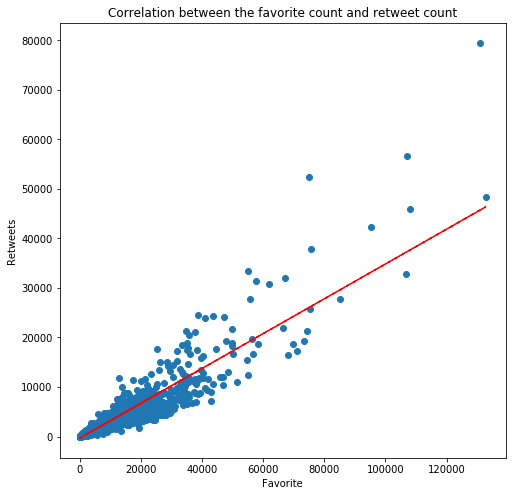

In [121]:
# Configure plot
fig = plt.figure(figsize=(8, 8))
plt.scatter(archive_clean_df.favorite_count, archive_clean_df.retweet_count)
plt.title("Correlation between the favorite count and retweet count")
plt.xlabel("Favorite")
plt.ylabel("Retweets")

#Configure trendline
z = np.polyfit(archive_clean_df.favorite_count, archive_clean_df.retweet_count, 1)
p = np.poly1d(z)
plt.plot(archive_clean_df.favorite_count,p(archive_clean_df.favorite_count),"r--")

plt.show();

From the chart above, we can see that we have a positive correlation between the number of likes and retweets our tweets receive.

We can dig deeper to get the top liked and retweeted tweets in our dataset. Let's get the top 10 of each of these values:

In [122]:
archive_clean_df.favorite_count.nlargest(10)

348    132810
862    131075
63     107956
445    107015
119    106827
374     95450
103     85011
447     75639
147     75193
901     75163
Name: favorite_count, dtype: int64

From this, we can see that tweet #348 is the most liked tweet in our dataset, which was liked 132,810 times.

Now, let's get the least 10 liked tweets in our dataset:

In [123]:
archive_clean_df.favorite_count.nsmallest(10)

1116     52
287      72
2158     81
2117     88
2138    107
2156    108
2170    111
2146    113
902     115
2165    115
Name: favorite_count, dtype: int64

Similarily, we can get the top retweeted tweets in our dataset:

In [124]:
archive_clean_df.retweet_count.nlargest(10)

862     79515
445     56625
901     52360
348     48265
63      45849
374     42228
447     37911
705     33421
119     32883
1651    31989
Name: retweet_count, dtype: int64

In [125]:
archive_clean_df.retweet_count.nsmallest(10)

247      0
1116     2
101      3
234      3
287      3
29       4
902      6
52       7
61      10
358     10
Name: retweet_count, dtype: int64

Tweet #862 is the most retweeted tweet in our dataset, which was retweeted 79,515 times, whereas tweet #247 got no retweets at all making it the least retweeted post in our dataset.

Now, let's take a look at the top 10 dog breeds in our dataset.

In [126]:
archive_clean_df.probability.value_counts().nlargest(10)

Golden Retriever      139
Labrador Retriever     95
Pembroke               88
Chihuahua              79
Pug                    54
Chow                   41
Samoyed                40
Toy Poodle             38
Pomeranian             38
Malamute               29
Name: probability, dtype: int64

People seem to love Golden Retrievers! Let's plot a bar chart to graphically represent this.

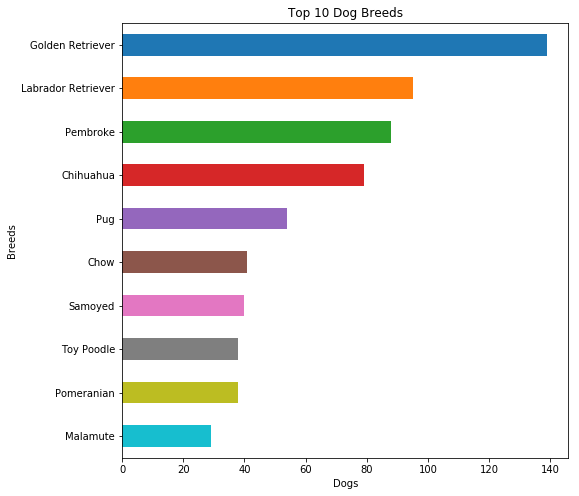

In [127]:
# Create a bar chart for the top 10 dog breeds in the dataset
top_10_dog_breeds = archive_clean_df.probability.value_counts().nlargest(10)
top_10_dog_breeds.plot(kind="barh", figsize=(8,8));
plt.xlabel("Dogs")
plt.ylabel("Breeds")
plt.title("Top 10 Dog Breeds")
plt.gca().invert_yaxis()
plt.show();

We can also take a look at the people's favorite dog stage. From the data below, we can see that most of our tweets are about puppers. Puppies are so cute, no wonder why people love them so much!

In [128]:
archive_clean_df.stage.value_counts()

pupper            224
doggo              75
puppo              24
doggo, pupper      10
floofer             9
doggo, floofer      1
doggo, puppo        1
Name: stage, dtype: int64

As we see below, both Lucy (for female dogs), and Charlie (for male dogs) are the most used name dog names, each accounting for 11 retweets.

In [129]:
archive_clean_df.name.value_counts().nlargest(10)

Lucy       11
Charlie    11
Cooper     10
Oliver     10
Tucker      9
Penny       9
Winston     8
Lola        8
Sadie       8
Toby        7
Name: name, dtype: int64

The pie chart below shows that only 74% of the images in our dataset are for dogs.

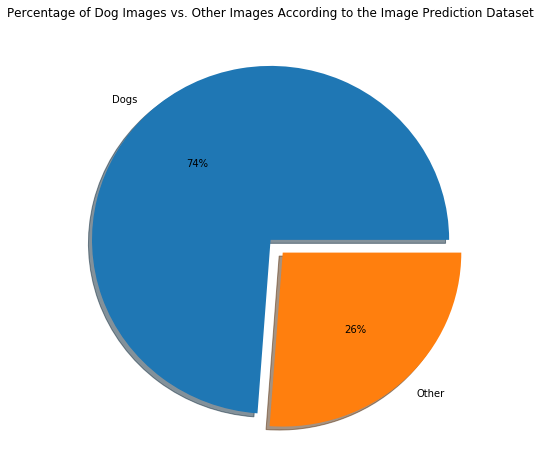

In [130]:
dog_image_count = len(prediction_clean_df[prediction_clean_df.is_dog])
non_dog_image_count = len(prediction_clean_df[~prediction_clean_df.is_dog])

_labels = ["Dogs", "Other"]
_values = [dog_image_count, non_dog_image_count]
_explode = [0, 0.1]
fig= plt.figure(figsize=(8, 8))
plt.title("Percentage of Dog Images vs. Other Images According to the Image Prediction Dataset")
plt.pie(_values, labels = _labels, explode=_explode, shadow=True, 
        autopct='%.0f%%')
plt.show();